# Spaceship Titanic

For my final project I wanted to try and solve the Spaceship Titanic competition from Kaggle

https://www.kaggle.com/competitions/spaceship-titanic

## Description of the Problem/Data

**Description**
After spaceship accident we are tasked to predict which passangers were transported due to the accident based on record recovered from the spaceship

**Data**
The dataset is a set of records for 8700 passangers with the following information
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [ ]:
!pip -q install kaggle matplotlib seaborn

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, Dropout, LeakyReLU, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2 

2024-04-25 05:10:47.391064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 05:10:47.391097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 05:10:47.392018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 05:10:47.397132: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
!kaggle competitions download -c spaceship-titanic

In [ ]:
!unzip spaceship-titanic.zip

## Exploratory Data Analysis
I will start by examining the structure and distributions of the dataset, checking for missing values, and visualizing various features to understand their impact on the target variable ('Transported').

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
<c

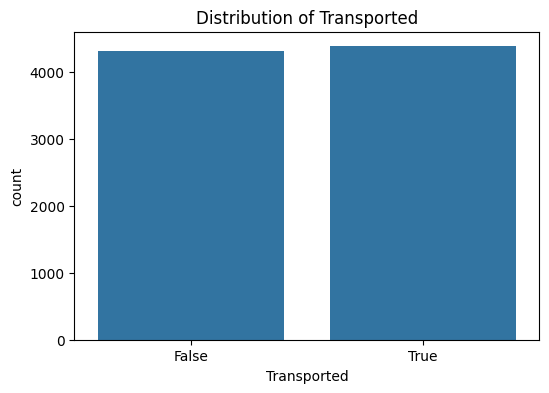

In [2]:
df = pd.read_csv('train.csv')

print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=df)
plt.title('Distribution of Transported')
plt.show()

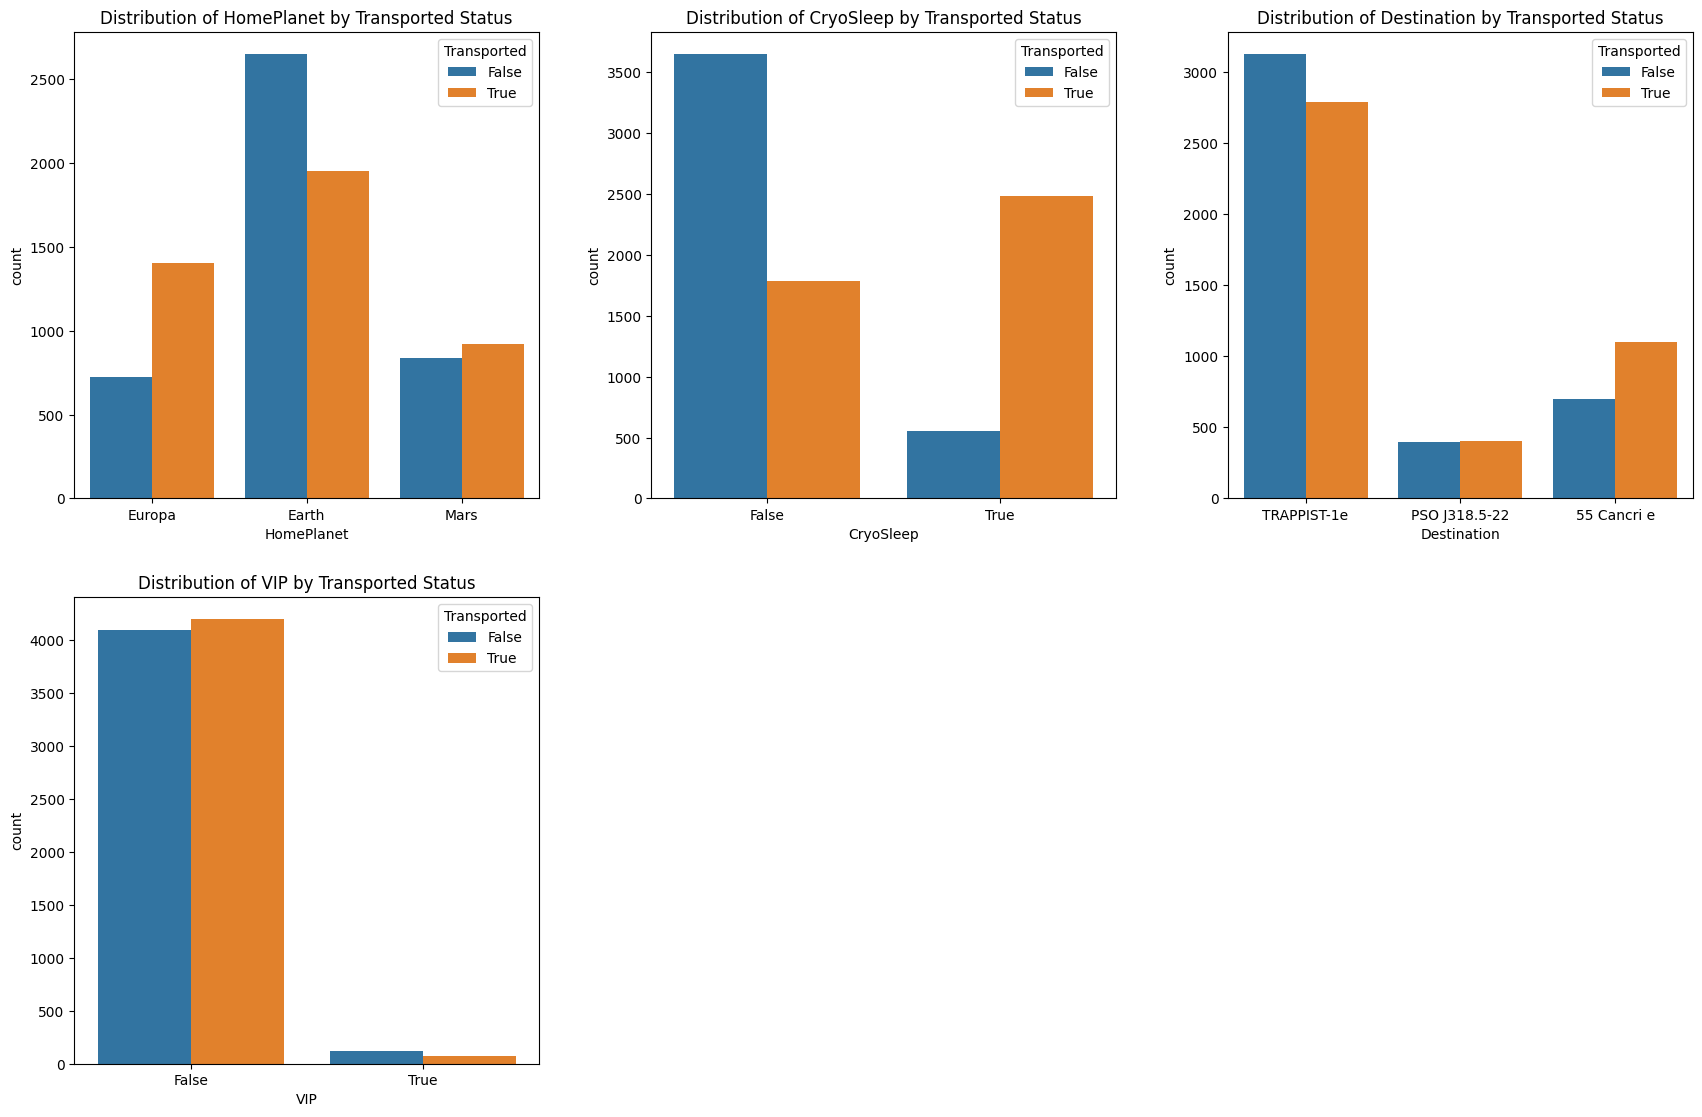

In [3]:

categorical_vars = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(nrows=int(len(categorical_vars)/3)+1, ncols=3, figsize=(18, 12))
fig.tight_layout(pad=5.0)

for i, var in enumerate(categorical_vars):
    row = i // 3
    col = i % 3
    sns.countplot(x=var, hue='Transported', data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {var} by Transported Status')

for j in range(i+1, axes.size):
    fig.delaxes(axes.flatten()[j])

plt.show()

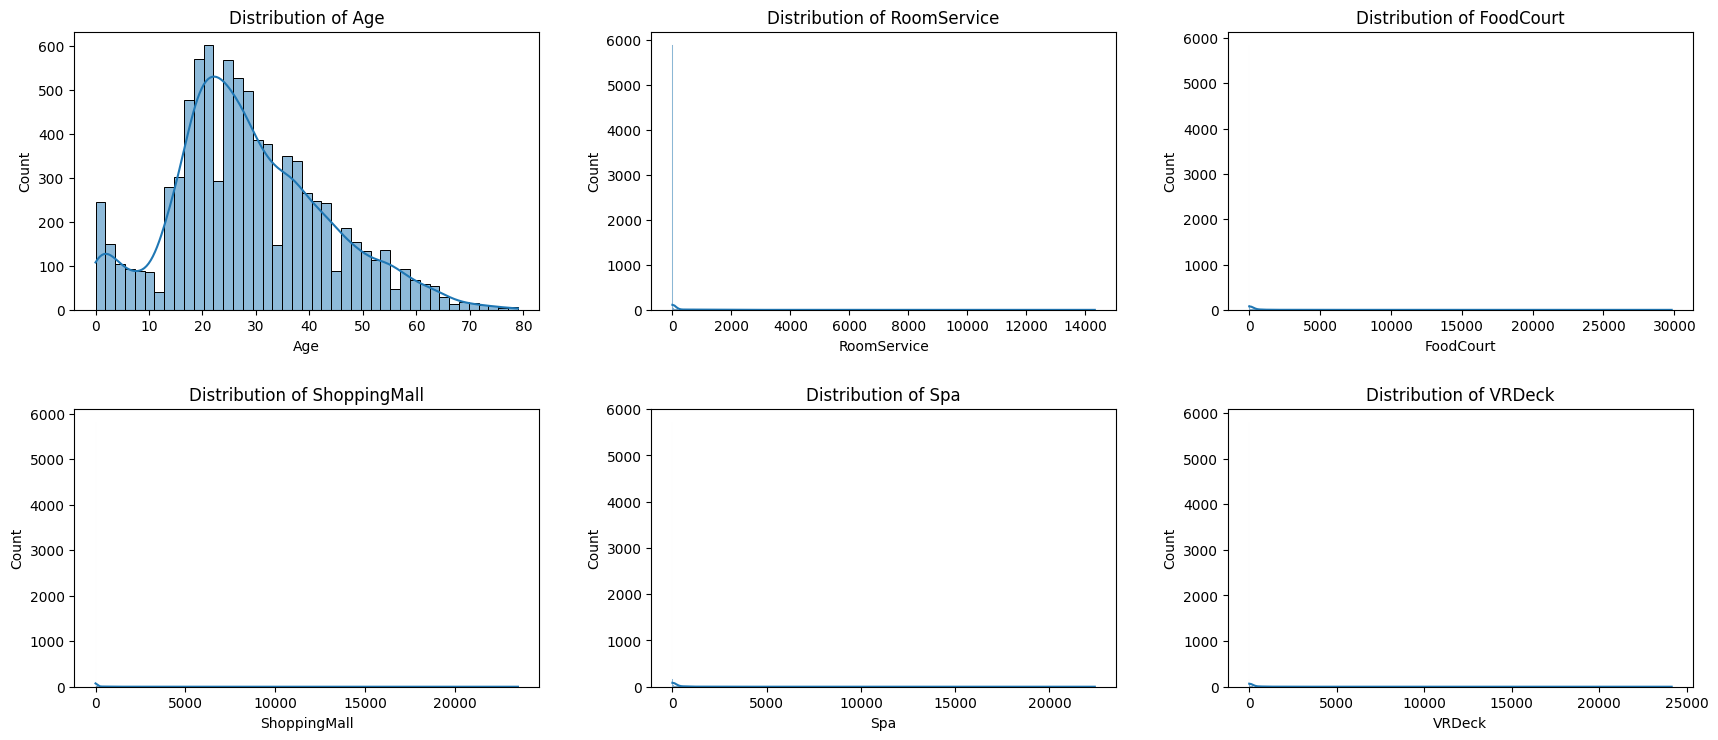

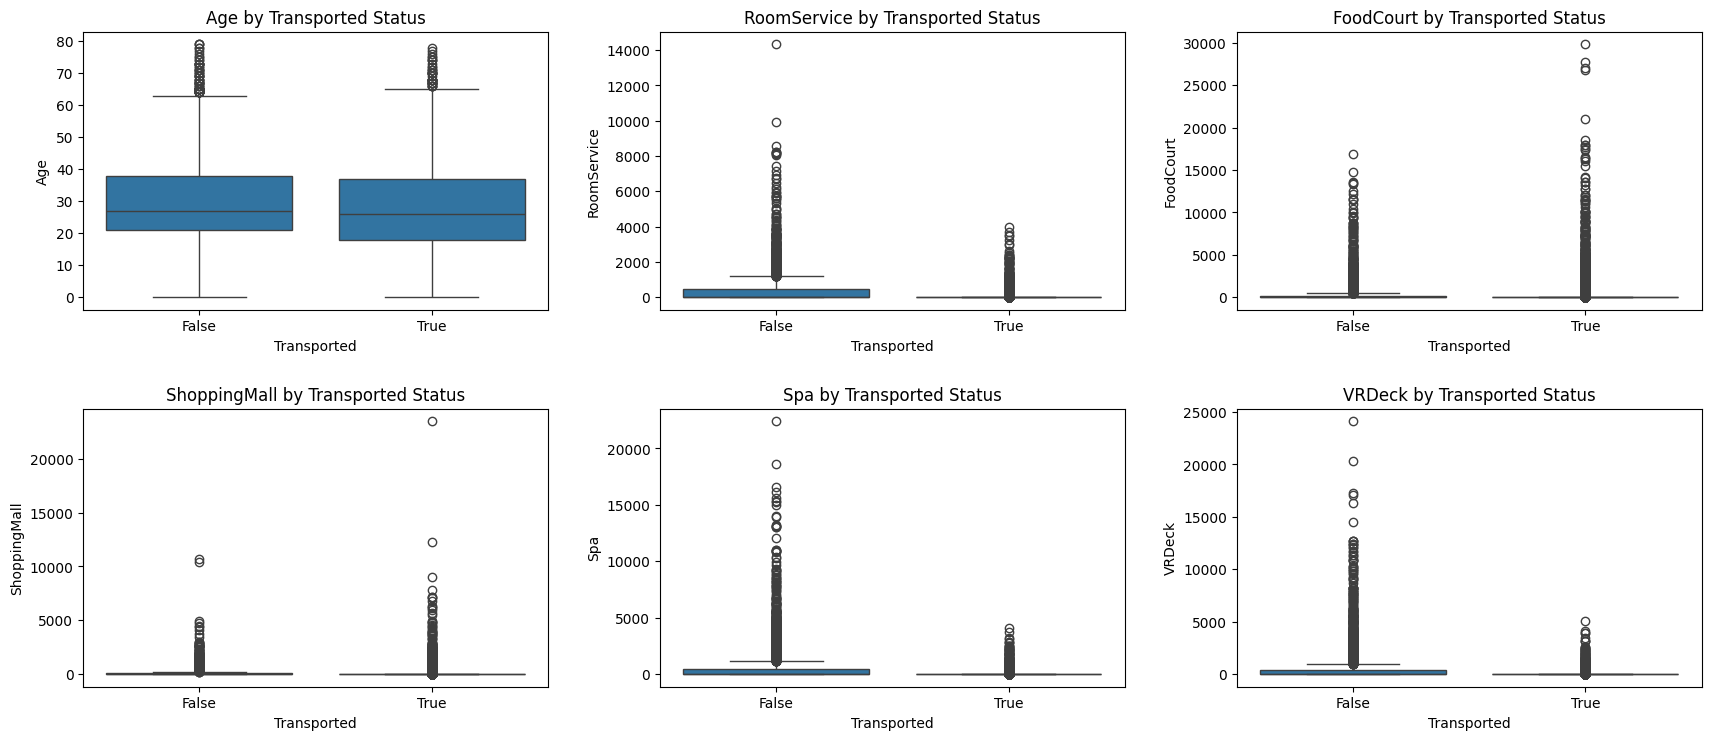

In [4]:
# Define numerical variables
numerical_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Set up the matplotlib figure for histograms
fig, axes = plt.subplots(nrows=int(len(numerical_vars)/3)+1, ncols=3, figsize=(18, 12))
fig.tight_layout(pad=5.0)

# Plotting the histograms for numerical variables three to a row
for i, var in enumerate(numerical_vars):
    row = i // 3
    col = i % 3
    sns.histplot(df[var].dropna(), kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {var}')

# Hide any unused subplots if the number of plots is not a multiple of 3
for j in range(i+1, axes.size):
    fig.delaxes(axes.flatten()[j])

plt.show()

# Set up the matplotlib figure for boxplots
fig, axes = plt.subplots(nrows=int(len(numerical_vars)/3)+1, ncols=3, figsize=(18, 12))
fig.tight_layout(pad=5.0)

# Plotting the boxplots for numerical variables three to a row
for i, var in enumerate(numerical_vars):
    row = i // 3
    col = i % 3
    sns.boxplot(x='Transported', y=var, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{var} by Transported Status')

# Hide any unused subplots if the number of plots is not a multiple of 3
for j in range(i+1, axes.size):
    fig.delaxes(axes.flatten()[j])

plt.show()

### Analysis
There are clear differences in transport rates depending on the HomePlanet. Europa has a higher rate of transport than Earth and Mars. 

CryoSleep appears to be a strong predictor, as a significant proportion of passengers in cryosleep were transported.

The transport rates vary by destination

Being a VIP seems to have less of an impact on the likelihood of being transported, as seen by the relatively small differences in counts. 

The mean age is slightly lower for those transported, and there's a noticeable difference in the distribution of ages between those transported and those not. 

Expenditure Features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)
These features have wide ranges and are heavily skewed, with many zeros. The means are significantly different when split by the 'Transported' status, which suggests that these features are useful for predicting the target. 

For data I will:
1. Log transform and scale numerical features
2. Encode categorical features

### Data Preparation

In [29]:
X = df.drop('Transported', axis=1)
y = df['Transported'].astype(int)  # Ensure the target is integer

# Impute missing values for numerical columns with median
num_imputer = SimpleImputer(strategy='median')

# Log transform and scale numerical features
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numerical_transformer = Pipeline(steps=[
    ('imputer', num_imputer),
    ('log', FunctionTransformer(np.log1p, validate=False)),  # Log transformation
    ('scaler', StandardScaler())  # Standardize features
])

# Encode categorical features
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

## Model Building and Training
I am going with a dual, stacked model approach

**Model 1: Basic Deep Neural Network (DNN)**

Architecture:
* Input Layer: Matches the number of preprocessed features.
* Hidden Layers: Several dense layers, e.g., three layers with diminishing number of neurons (e.g., 128, 64, 32). This structure allows the network to learn a hierarchy of features with different levels of abstraction.
* Activation Functions: ReLU (Rectified Linear Unit) for hidden layers due to its efficiency and effectiveness in avoiding vanishing gradient problems.
* Dropout Layers: Incorporated between layers to reduce overfitting by randomly setting input units to 0 at each update during training.
* Output Layer: A single neuron with a sigmoid activation function to output a probability of being transported.

**Model 2: Convolutional Neural Network (CNN) for Feature Interactions**
Although CNNs are typically used for image processing, they can be adapted for tabular data to capture local patterns or interactions between features, assuming features are ordered in a meaningful way.

Architecture:
* Input Reshaping: Reshape input data to a 1D convolution-friendly format.
* 1D Convolutional Layers: Use several 1D convolutions to extract local feature interactions. These can highlight useful patterns across adjacent data points (features) if they are thoughtfully ordered.
* Pooling Layers: Max pooling following convolutions to reduce dimensionality and focus on the most relevant extracted features.
* Flattening: Flatten the output of convolutional layers to feed into a dense layer.
* Dense Layer: A dense layer after the convolutions to interpret the features followed by a dropout for regularization.
* Output Layer: Same as in Model 1, using a sigmoid function for binary classification.

**Stacked Model Approach**
Once both models are trained, their predictions (probabilities) can be used as input features for a new, smaller neural network or a different model (like logistic regression) to make the final prediction. This stacking approach leverages the strengths and different perspectives of both models.

Stacking Architecture:
* Input: Outputs of Model 1 and Model 2 (probabilities of being transported).
* Hidden Layer: A dense layer to combine these features.
* Output Layer: A single neuron with a sigmoid activation function to give the final prediction probability.

In [11]:
def plot_model_performance(history, model_name="Model"):
    # Extract the final loss and accuracy from the history object
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    
    # Print final loss and accuracy
    print(f"{model_name} Final Training Loss: {final_train_loss:.4f}")
    print(f"{model_name} Final Validation Loss: {final_val_loss:.4f}")
    print(f"{model_name} Final Training Accuracy: {final_train_accuracy:.4f}")
    print(f"{model_name} Final Validation Accuracy: {final_val_accuracy:.4f}")

    # Create a figure with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation loss in the first subplot
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot training & validation accuracy in the second subplot
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Show the plot
    plt.show()

In [12]:
def create_dnn_model(input_shape):
    model = Sequential([
        Dense(512, input_dim=input_shape, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(512, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(256, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),

        Dense(256, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),

        Dense(128, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.1),

        Dense(1, activation='sigmoid')
    ])
    return model

def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [14]:
dnn_model = create_dnn_model(input_shape=X_train.shape[1])

initial_learning_rate = 1e-4
epoch = 500
batch_size = 32
total_samples = X_train.shape[0]
epochs_per_decay = 2
steps_per_epoch = total_samples // batch_size
decay_steps = steps_per_epoch * epochs_per_decay

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.8,
    staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

dnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = dnn_model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=epoch, batch_size=batch_size,
          verbose=2,
          callbacks=[reduce_lr, early_stopping])

Epoch 1/500
218/218 - 3s - loss: 0.5902 - accuracy: 0.6969 - val_loss: 0.4871 - val_accuracy: 0.7683 - lr: 1.0000e-04 - 3s/epoch - 16ms/step
Epoch 2/500
218/218 - 2s - loss: 0.5290 - accuracy: 0.7440 - val_loss: 0.4746 - val_accuracy: 0.7729 - lr: 8.0000e-05 - 2s/epoch - 7ms/step
Epoch 3/500
218/218 - 2s - loss: 0.5201 - accuracy: 0.7483 - val_loss: 0.4695 - val_accuracy: 0.7734 - lr: 8.0000e-05 - 2s/epoch - 7ms/step
Epoch 4/500
218/218 - 1s - loss: 0.5063 - accuracy: 0.7535 - val_loss: 0.4626 - val_accuracy: 0.7746 - lr: 6.4000e-05 - 1s/epoch - 6ms/step
Epoch 5/500
218/218 - 1s - loss: 0.5034 - accuracy: 0.7603 - val_loss: 0.4624 - val_accuracy: 0.7775 - lr: 6.4000e-05 - 1s/epoch - 5ms/step
Epoch 6/500
218/218 - 1s - loss: 0.4951 - accuracy: 0.7622 - val_loss: 0.4581 - val_accuracy: 0.7803 - lr: 5.1200e-05 - 1s/epoch - 5ms/step
Epoch 7/500
218/218 - 1s - loss: 0.4986 - accuracy: 0.7653 - val_loss: 0.4581 - val_accuracy: 0.7786 - lr: 5.1200e-05 - 1s/epoch - 6ms/step
Epoch 8/500
218/218

DNN Model Final Training Loss: 0.4830
DNN Model Final Validation Loss: 0.4486
DNN Model Final Training Accuracy: 0.7706
DNN Model Final Validation Accuracy: 0.7792


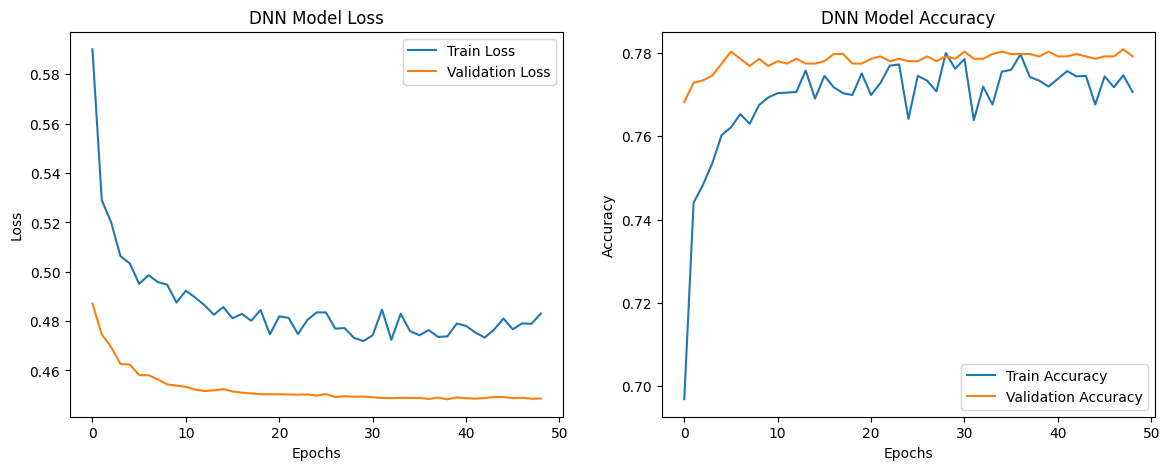

In [15]:
plot_model_performance(history, model_name="DNN Model")

In [16]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

cnn_model = create_cnn_model((X_train_reshaped.shape[1], 1))

initial_learning_rate = 1e-4
epoch = 500
batch_size = 32
total_samples = X_train.shape[0]
epochs_per_decay = 2
steps_per_epoch = total_samples // batch_size
decay_steps = steps_per_epoch * epochs_per_decay

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.8,
    staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Training the CNN model
history = cnn_model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val),
              epochs=epoch, batch_size=batch_size,
              verbose=2,
              callbacks=[reduce_lr, early_stopping])

Epoch 1/500
218/218 - 3s - loss: 0.5750 - accuracy: 0.7262 - val_loss: 0.5009 - val_accuracy: 0.7614 - lr: 1.0000e-04 - 3s/epoch - 12ms/step
Epoch 2/500
218/218 - 1s - loss: 0.4893 - accuracy: 0.7689 - val_loss: 0.4707 - val_accuracy: 0.7740 - lr: 8.0000e-05 - 1s/epoch - 5ms/step
Epoch 3/500
218/218 - 1s - loss: 0.4646 - accuracy: 0.7833 - val_loss: 0.4673 - val_accuracy: 0.7815 - lr: 8.0000e-05 - 726ms/epoch - 3ms/step
Epoch 4/500
218/218 - 1s - loss: 0.4574 - accuracy: 0.7903 - val_loss: 0.4637 - val_accuracy: 0.7792 - lr: 6.4000e-05 - 909ms/epoch - 4ms/step
Epoch 5/500
218/218 - 1s - loss: 0.4527 - accuracy: 0.7934 - val_loss: 0.4613 - val_accuracy: 0.7786 - lr: 6.4000e-05 - 911ms/epoch - 4ms/step
Epoch 6/500
218/218 - 1s - loss: 0.4482 - accuracy: 0.7958 - val_loss: 0.4573 - val_accuracy: 0.7821 - lr: 5.1200e-05 - 862ms/epoch - 4ms/step
Epoch 7/500
218/218 - 1s - loss: 0.4425 - accuracy: 0.8003 - val_loss: 0.4572 - val_accuracy: 0.7815 - lr: 5.1200e-05 - 706ms/epoch - 3ms/step
Epoc

CNN Model Final Training Loss: 0.4268
CNN Model Final Validation Loss: 0.4522
CNN Model Final Training Accuracy: 0.8049
CNN Model Final Validation Accuracy: 0.7861


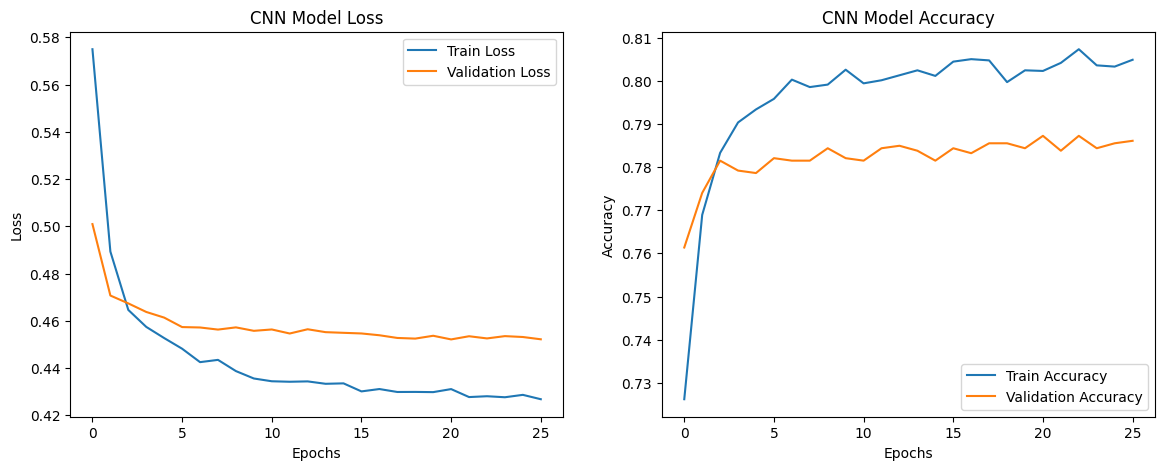

In [17]:
plot_model_performance(history, model_name="CNN Model")

In [23]:
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Generate predictions from both models
dnn_predictions = dnn_model.predict(X_val)
cnn_predictions = cnn_model.predict(X_val_reshaped)

# Ensure predictions are flattened if they're not already (depends on model output layer)
dnn_predictions = dnn_predictions.flatten()
cnn_predictions = cnn_predictions.flatten()

stacked_features = np.column_stack((dnn_predictions, cnn_predictions))

55/55 [==============================] - 0s 805us/step


In [24]:
def create_stacked_model():
    model = Sequential([
        Dense(10, activation='relu', input_dim=2),  # Input dimension = 2 predictions
        Dense(20, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model


In [25]:
initial_learning_rate = 1e-4
epoch = 500
batch_size = 8
total_samples = X_train.shape[0]
epochs_per_decay = 2
steps_per_epoch = total_samples // batch_size
decay_steps = steps_per_epoch * epochs_per_decay

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,  # Adjust based on your specific needs
    decay_rate=0.8,
    staircase=True)

# Set up the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Assuming you have a function to create your stacked model
stacked_model = create_stacked_model()
stacked_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = stacked_model.fit(stacked_features, y_val, epochs=epoch, batch_size=batch_size,
                            validation_split=0.2,  # Assuming you have enough data to split off a validation set
                            verbose=2,
                            callbacks=[reduce_lr, early_stopping])

Epoch 1/500
174/174 - 1s - loss: 0.6705 - accuracy: 0.5075 - val_loss: 0.6652 - val_accuracy: 0.5431 - lr: 1.0000e-04 - 1s/epoch - 7ms/step
Epoch 2/500
174/174 - 1s - loss: 0.6613 - accuracy: 0.5392 - val_loss: 0.6551 - val_accuracy: 0.6092 - lr: 1.0000e-04 - 526ms/epoch - 3ms/step
Epoch 3/500
174/174 - 1s - loss: 0.6516 - accuracy: 0.5838 - val_loss: 0.6431 - val_accuracy: 0.6523 - lr: 1.0000e-04 - 544ms/epoch - 3ms/step
Epoch 4/500
174/174 - 1s - loss: 0.6389 - accuracy: 0.6233 - val_loss: 0.6274 - val_accuracy: 0.6925 - lr: 1.0000e-04 - 515ms/epoch - 3ms/step
Epoch 5/500
174/174 - 0s - loss: 0.6286 - accuracy: 0.6564 - val_loss: 0.6136 - val_accuracy: 0.7356 - lr: 1.0000e-04 - 492ms/epoch - 3ms/step
Epoch 6/500
174/174 - 0s - loss: 0.6178 - accuracy: 0.6937 - val_loss: 0.6027 - val_accuracy: 0.7557 - lr: 1.0000e-04 - 497ms/epoch - 3ms/step
Epoch 7/500
174/174 - 0s - loss: 0.6072 - accuracy: 0.7203 - val_loss: 0.5915 - val_accuracy: 0.7644 - lr: 1.0000e-04 - 434ms/epoch - 2ms/step
Ep

Stacked Model Final Training Loss: 0.4779
Stacked Model Final Validation Loss: 0.4627
Stacked Model Final Training Accuracy: 0.7786
Stacked Model Final Validation Accuracy: 0.7759


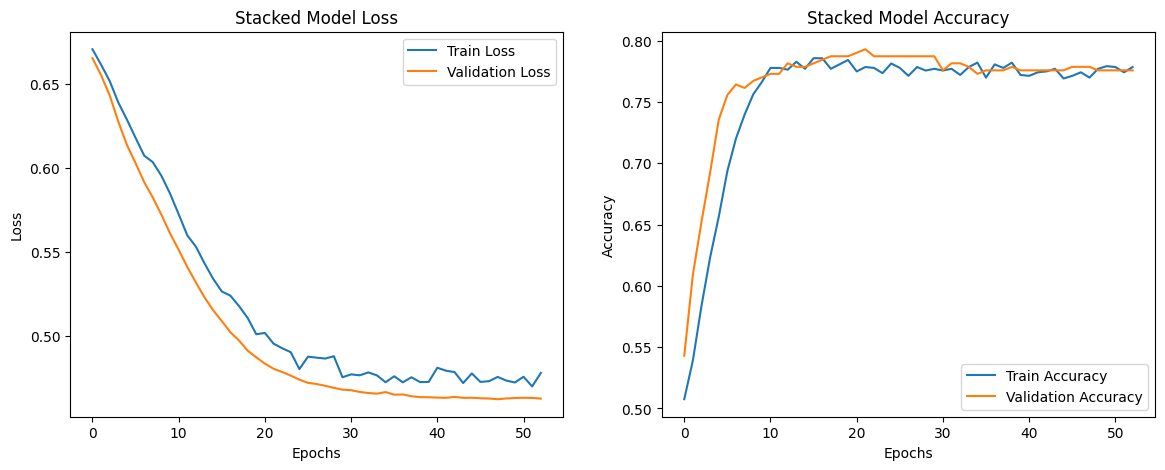

In [26]:
plot_model_performance(history, model_name="Stacked Model")

## Submission and Conclusion


In [33]:
test_df = pd.read_csv('test.csv')

num_imputer = SimpleImputer(strategy='median')
numerical_transformer = Pipeline(steps=[
    ('imputer', num_imputer),
    ('log', FunctionTransformer(np.log1p, validate=False)),  # Log transformation
    ('scaler', StandardScaler())  # Standardize features
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')


X_test = test_df.drop(['PassengerId'], axis=1)  # Drop 'PassengerId' temporarily for processing
X_test_processed = preprocessor.transform(X_test)
X_test_reshaped = X_test_processed.reshape((X_test_processed.shape[0], X_test_processed.shape[1], 1))  

In [37]:
predictions_dnn = dnn_model.predict(X_test_processed)
predictions_cnn = cnn_model.predict(X_test_reshaped)
stacked_input = np.column_stack((predictions_dnn, predictions_cnn))
predictions_stacked = stacked_model.predict(stacked_input)

134/134 [==============================] - 0s 723us/step


In [40]:
predictions_dnn = (predictions_dnn > 0.5)
predictions_cnn = (predictions_cnn > 0.5)
predictions_stacked = (predictions_stacked > 0.5)

output_dnn = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': predictions_dnn.flatten()})
output_dnn.to_csv('predictions_dnn.csv', index=False)

output_cnn = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': predictions_cnn.flatten()})
output_cnn.to_csv('predictions_cnn.csv', index=False)

output_stacked = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': predictions_stacked.flatten()})
output_stacked.to_csv('predictions_stacked.csv', index=False)


In [41]:
# Averaging predictions for ensemble effect
ensemble_predictions = (predictions_dnn + predictions_cnn + predictions_stacked) / 3
ensemble_predictions = (ensemble_predictions > 0.5)

# Save ensemble predictions
output_ensemble = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': ensemble_predictions.flatten()})
output_ensemble.to_csv('predictions_ensemble.csv', index=False)


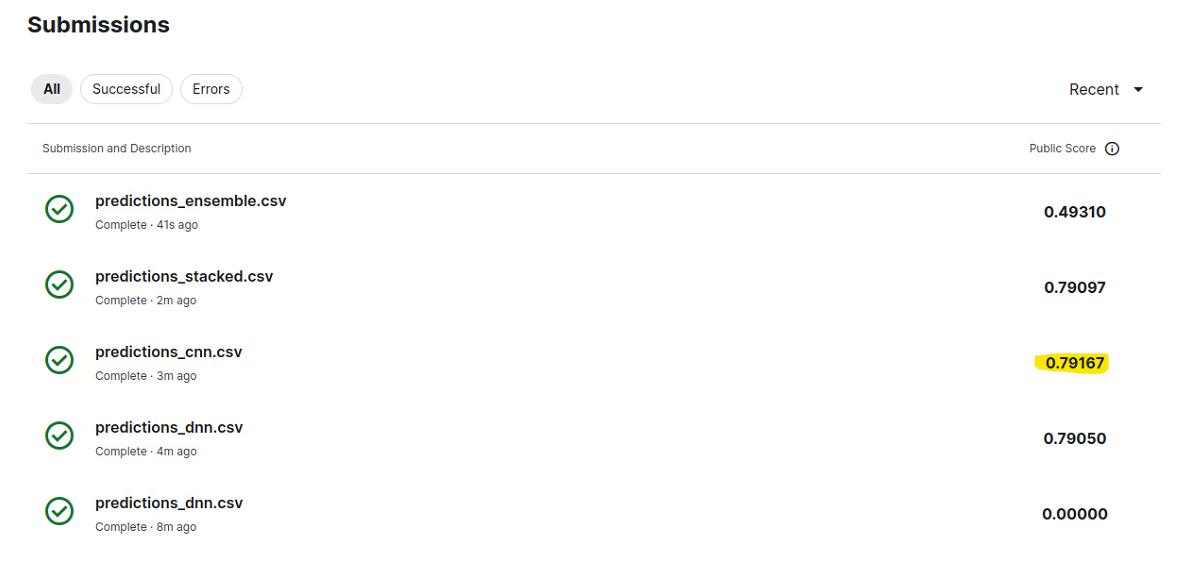


In the analysis of the prediction models for the "Spaceship Titanic" competition, the results reveal that both the Convolutional Neural Network (CNN) and the Deep Neural Network (DNN) models performed similarly, with the CNN slightly outperforming the DNN, achieving scores of 0.7917 and 0.7905 respectively. The stacked model, which was designed to potentially leverage the strengths of both the CNN and DNN by combining their outputs, yielded a score very close to that of the DNN, at 0.79097. Surprisingly, the ensemble approach, which combined predictions from all three models, resulted in a significantly lower score of 0.49310, suggesting that the method of combining the models might have been suboptimal or that these models' predictions were too correlated to benefit from simple averaging.

The observations suggest that while the individual CNN and DNN models are quite robust on their own, the slight edge of the CNN could be attributed to its ability to capture spatial hierarchies in data, which might be slightly more aligned with the nature of the structured inputs used in this case. The underperformance of the ensemble model highlights the challenges in effective model ensembling; it indicates that mere averaging of outputs can dilute the predictive power if not done cautiously. It is advisable to explore more sophisticated ensemble techniques, such as weighted averaging based on validation performance, or using a meta-model to integrate predictions more effectively. Additionally, future efforts could focus on further tuning the hyperparameters of the CNN and DNN models, exploring alternative advanced ensembling methods, and experimenting with more complex architectures or feature engineering techniques to potentially boost the predictive accuracy further.